In [21]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dropout,LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

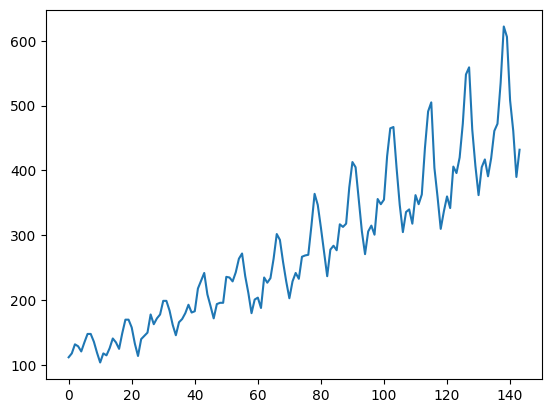

In [23]:
dataset = pd.read_csv("/content/drive/MyDrive/Airline_passengers/airline-passengers.csv",usecols =[1],engine = "python")
plt.plot(dataset)
np.random.seed(7) #seed ngẫu nhiên để tái sử dụng
plt.show()

In [24]:
dataset = dataset.values
dataset = dataset.astype('float32')

In [25]:
#chuẩn hóa dữ liệu vì LSTM nhạy cảm với dữ liệu
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [26]:
# chia bộ dữ liệu 66% cho train còn lại cho test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [27]:
def creat_dataset(dataset , look_back = 1):
    dataX,dataY =[],[] #X :số khách tại thời điểm t ,Y : số khách tại thời điểm t+1
    for i in range(len(dataset)- look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)



In [28]:
#reshape into X = 1 va Y = t+1
#tạo bộ dữ liệu mới áp dụng RNN , LSTM
look_back = 1
trainX , trainY = creat_dataset(train,look_back)
testX,testY = creat_dataset(test,look_back)
#reshape input cho [samples , time steps , features]
#thêm dạng dữ liệu đầu vào thích hợp cho quá trình train mạng LSTM
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

## LSTM NETWORK For Regression

In [29]:
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0363 - 2s/epoch - 24ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0176 - 465ms/epoch - 5ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0145 - 260ms/epoch - 3ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0133 - 257ms/epoch - 3ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0122 - 260ms/epoch - 3ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0113 - 338ms/epoch - 4ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0104 - 343ms/epoch - 4ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0095 - 239ms/epoch - 3ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0086 - 263ms/epoch - 3ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0079 - 249ms/epoch - 3ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0071 - 250ms/epoch - 3ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0064 - 232ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0057 - 263ms/epoch - 3ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0051 - 248ms/epoch - 3ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0046 - 242ms/epoch - 3ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0040 - 240ms/epoc

In [30]:
# Dự đoán dữ liệu test
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Làm ngược dự đoán trrước khi tính lỗi để đảm bảo cùng đơn vị dữ liệu đầu
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Tính toán hàm mất mát
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 5ms/step
Train Score: 22.60 RMSE
Test Score: 52.32 RMSE


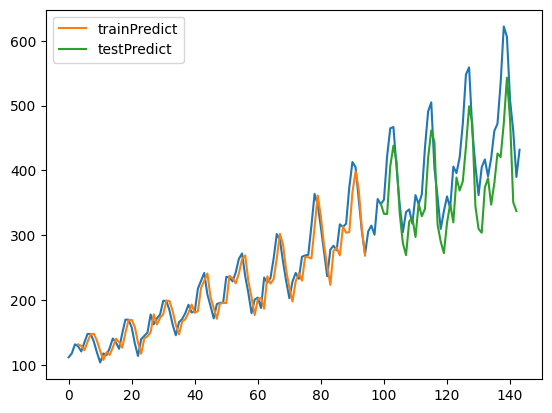

In [83]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,label ="trainPredict")
plt.plot(testPredictPlot,label = "testPredict")
plt.legend()
plt.show()

## LSTM For Regression Using the Window Method
 + Về cơ bản ta có thể tạo chuỗi dữ liệu thời gian mà đầu ra tại thời điểm t chỉ phụ thuộc vào dữ liệu ngay trước tại thời điểm t-1. Đây là trường hợp lý tưởng và đơn giản nhât cho việc dữ liệu tại thời điêm t có thể phụ thuộc vào rất nhiều dữ liệu trước -> phương pháp window.

In [71]:
# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Airline_passengers/airline-passengers.csv',usecols = [1],engine = "python")
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1

def create_dataset(dataset , look_back =3):
    dataX,dataY =[],[] #X :số khách tại thời điểm t ,Y : số khách tại thời điểm t+1
    for i in range(len(dataset)- look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [72]:
print(trainX)

[[[0.01544401 0.02702703 0.05405405]]

 [[0.02702703 0.05405405 0.04826255]]

 [[0.05405405 0.04826255 0.03281853]]

 [[0.04826255 0.03281853 0.05984557]]

 [[0.03281853 0.05984557 0.08494207]]

 [[0.05984557 0.08494207 0.08494207]]

 [[0.08494207 0.08494207 0.06177607]]

 [[0.08494207 0.06177607 0.02895753]]

 [[0.06177607 0.02895753 0.        ]]

 [[0.02895753 0.         0.02702703]]

 [[0.         0.02702703 0.02123553]]

 [[0.02702703 0.02123553 0.04247104]]

 [[0.02123553 0.04247104 0.07142857]]

 [[0.04247104 0.07142857 0.05984557]]

 [[0.07142857 0.05984557 0.04054055]]

 [[0.05984557 0.04054055 0.08687258]]

 [[0.04054055 0.08687258 0.12741312]]

 [[0.08687258 0.12741312 0.12741312]]

 [[0.12741312 0.12741312 0.10424709]]

 [[0.12741312 0.10424709 0.05598456]]

 [[0.10424709 0.05598456 0.01930502]]

 [[0.05598456 0.01930502 0.06949806]]

 [[0.01930502 0.06949806 0.07915059]]

 [[0.06949806 0.07915059 0.08880308]]

 [[0.07915059 0.08880308 0.14285713]]

 [[0.08880308 0.14285713 

In [73]:
print(trainY)

[0.04826255 0.03281853 0.05984557 0.08494207 0.08494207 0.06177607
 0.02895753 0.         0.02702703 0.02123553 0.04247104 0.07142857
 0.05984557 0.04054055 0.08687258 0.12741312 0.12741312 0.10424709
 0.05598456 0.01930502 0.06949806 0.07915059 0.08880308 0.14285713
 0.11389962 0.13127413 0.14285713 0.18339768 0.18339768 0.15444016
 0.11196911 0.08108109 0.1196911  0.12934363 0.14671814 0.17181468
 0.14864865 0.15250966 0.22007722 0.24324325 0.26640925 0.2027027
 0.16795367 0.13127413 0.17374519 0.17760617 0.17760617 0.25482625
 0.25289574 0.24131274 0.26833975 0.3088803  0.32432434 0.25675675
 0.20656371 0.14671814 0.18725869 0.19305018 0.16216215 0.25289574
 0.23745173 0.25096524 0.3088803  0.38223937 0.36486486 0.2992278
 0.24131274 0.1911197  0.24131274 0.26640925 0.24903473 0.31467178
 0.3185328  0.32046333 0.4073359  0.5019305  0.46911195 0.40154442
 0.32818535 0.25675675 0.3359073  0.34749034 0.33397684 0.41119692
 0.4034749  0.4131274  0.52123547 0.5965251  0.58108103 0.484556

In [74]:
model = Sequential()
model.add(LSTM(4,input_shape = (1,look_back)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer ="adam")
model.fit(trainX,trainY,epochs= 100,batch_size = 1,verbose = True)

Epoch 1/100
92/92 [==============================] - 2s 3ms/step - loss: 0.0434
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 5/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 6/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 7/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 8/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 9/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 10/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 11/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 12/100
92/92 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 13/100
92/92 [=================

In [75]:
#dự đoán
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#inver predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#calculate root mean squaed error
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print("TrainScore :{:.2f} RMSE".format(trainScore))
testScore = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print("TestScore : {: .2f}".format(testScore))

2/2 [==============================] - 0s 6ms/step
TrainScore :21.87 RMSE
TestScore :  62.26


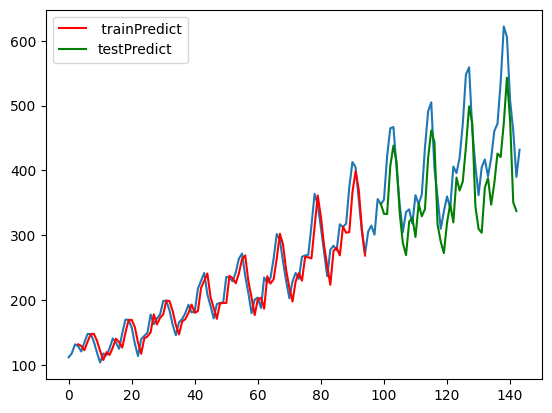

In [81]:
#train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict
#test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict
#plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,color = "red" , label = " trainPredict")
plt.plot(testPredictPlot,color = "green",label = "testPredict")
plt.legend()
plt.show()


##LSTM NETWOR for Regression with Time Steps
 + Thay vi cố định time steps như trước, ta sẽ coi toàn bộ dữ liệu trước trở thành tiền đề đề để sinh ra dự liệu sau

In [95]:
# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/Airline_passengers/airline-passengers.csv',usecols = [1],engine = "python")
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1

''' def create_dataset(dataset , look_back =3):
    dataX,dataY =[],[] #X :số khách tại thời điểm t ,Y : số khách tại thời điểm t+1
    for i in range(len(dataset)- look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY) '''

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))


In [96]:
model = Sequential()
model.add(LSTM(4,input_shape = (look_back,1)))
model.add(Dense(1))
model.compile(optimizer ="adam",loss ="mean_squared_error")
model.fit(trainX,trainY , verbose = 2, batch_size = 1,epochs = 100)

Epoch 1/100
92/92 - 2s - loss: 0.0197 - 2s/epoch - 20ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0083 - 253ms/epoch - 3ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0070 - 250ms/epoch - 3ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0062 - 247ms/epoch - 3ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0054 - 251ms/epoch - 3ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0048 - 261ms/epoch - 3ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0045 - 318ms/epoch - 3ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0042 - 329ms/epoch - 4ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0039 - 324ms/epoch - 4ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0038 - 322ms/epoch - 4ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0038 - 353ms/epoch - 4ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0037 - 340ms/epoch - 4ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0037 - 344ms/epoch - 4ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0036 - 326ms/epoch - 4ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0036 - 355ms/epoch - 4ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0036 - 350ms/epoc

In [98]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_tra nsform([testY])
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print("TrainScore : {:.2f} RMSE".format(trainScore))
testScore = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print("TestScore : {:.2f} RMSE".format(testScore))

2/2 [==============================] - 0s 7ms/step
TrainScore : 24.08 RMSE
TestScore : 58.59 RMSE


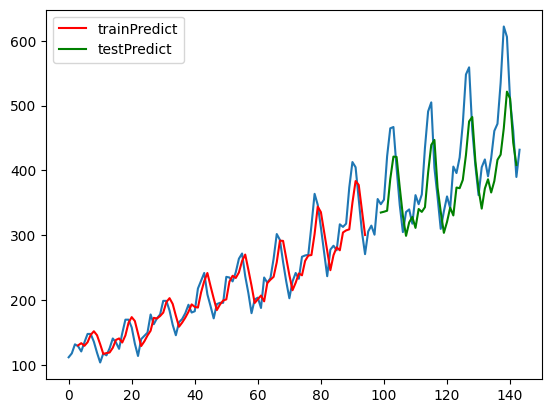

In [99]:
#train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back :len(trainPredict)+look_back,:] = trainPredict
#test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict
#plot
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,color ="red",label = "trainPredict")
plt.plot(testPredictPlot,color = "green",label = "testPredict")
plt.legend()
plt.show()

##TEST Neural Network

In [103]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras  import Sequential , layers,optimizers, losses
#fit random seed
np.random.seed(6)
#load data
dataframe = pd.read_csv('/content/drive/MyDrive/Airline_passengers/airline-passengers.csv',usecols = [1],engine = "python")
dataset = dataframe.values
dataset = dataset.astype('float32')
#normalize the data
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#reshape into trainX = 1, trainY = t+1
look_back = 3
trainX ,trainY = create_dataset(train,look_back)
testX,testY = create_dataset(test,look_back)
#simple model to recognize
model = tf.keras.Sequential()
model.add(layers.Flatten())

model.add(layers.Dense(3,activation = "relu"))
model.add(layers.Dense(1))
model.compile(loss = "mean_squared_error",optimizer = "adam")
model.fit(trainX,trainY,batch_size = 1,verbose = True,epochs = 50,validation_data = (testX,testY))

Epoch 1/50
92/92 [==============================] - 2s 5ms/step - loss: 0.0454 - val_loss: 0.1684
Epoch 2/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0840
Epoch 3/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0637
Epoch 4/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0468
Epoch 5/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0331
Epoch 6/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0259
Epoch 7/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0244
Epoch 8/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0156
Epoch 9/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0161
Epoch 10/50
92/92 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0127
Epoch 11/50
92/92 [